# Face Generation

The goal of this project is to define and train a DCGAN on a dataset of faces, to get a generator network that can generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, we'll be able to visualize the results of our trained Generator to see how it performs.

## Overall steps

The project consists of the following steps:

1. Get the data
   1. Preprocessed data
2. Visualize the CelebA data
   1. Preprocess and load the data
3. Create a DataLoader
   1. Create a DataLoader
4. Scale the data to a pixel range of -1 to 1
5. Define the Model
   1. Discriminator
   2. Generator
6. Initialize the weights of your networks
7. Build complete network
8. Discriminator and Generator Losses
   1. Discriminator loss
   2. Generator loss
9. Optimizers
10. Training
11. Visualize losses
12. Generate new samples
13. Observations

## Get the data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) we've been working with, and so, we should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that we utilize a GPU for training.

### Preprocessed data

In [54]:
# can comment out after executing
#unzip processed-celeba-small.zip

In [6]:
data_dir = 'data/'

import os
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Preprocess and load the data

Since the project's main focus is on building the GANs, Udacity has done *some* of the pre-processing. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

In [7]:
# necessary imports
import torch
from torch.utils.data import DataLoader 
from torchvision import datasets, transforms, utils
torch.backends.cudnn.deterministic=True
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

## Create a DataLoader

In [8]:
def get_dataloader(batch_size, image_size, data_dir='data/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # Implement function and return a dataloader
    transform = transforms.Compose([transforms.Scale(image_size), 
                                    transforms.ToTensor()])
    
    # get training and test directories
    train_path = os.path.join(data_dir, 'train_smaller')
    
    train_dataset = datasets.ImageFolder(train_path, transform)
    
    # create and return DataLoaders
    num_workers = 0
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    
    return train_loader


In [9]:
# Define function hyperparameters
batch_size = 32
img_size = 32

# Call your function and get a dataloader
celeb_train_loader = get_dataloader(batch_size, img_size, data_dir='data/')


Next, we can view some images! we should see square images of somewhat-centered faces.

Note: We'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

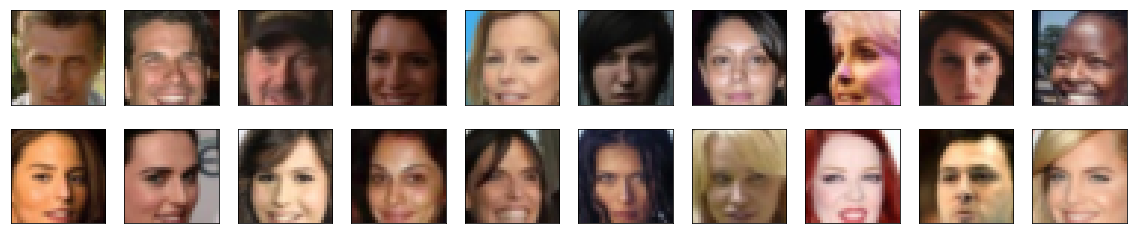

In [10]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# obtain one batch of training images
dataiter = iter(celeb_train_loader)
images, _ = dataiter.next() # _ for no labels

fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

## Scale the data to a pixel range of -1 to 1

We need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [11]:
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    out = x * (max - min) + min
    
    return out


In [12]:
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

# Before scaling
print('Min: ', img.min())
print('Max: ', img.max())

# After scaling
print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(0.0157)
Max:  tensor(0.9059)
Min:  tensor(-0.9686)
Max:  tensor(0.8118)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

This is a convolutional classifier like we've built before, only without any maxpooling layers. To deal with this complex data, it's suggested we use a deep network with **normalization**. We are also allowed to create any helper functions that may be useful.

* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake

In [13]:
import torch.nn as nn
import torch.nn.functional as F

In [14]:
def conv_block(input_dim, output_dim, kernel_size, stride=2, padding=1, group_norm=True):
    
    conv = nn.Conv2d(input_dim, output_dim, kernel_size, stride, padding, bias=False)
    layers = []
    layers.append(conv)
    if (group_norm):
        if output_dim%3 == 0:
            layers.append(nn.GroupNorm(3, output_dim))
        else:
            layers.append(nn.GroupNorm(2, output_dim))
        
    return nn.Sequential(*layers)

class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()
        
        self.conv_dim = conv_dim
        
        self.conv1 = conv_block(3, conv_dim, 3, group_norm=False) # 32x32x3 -> 16x16xconv_dim
        self.conv2 = conv_block(conv_dim, conv_dim*2, 3)             # 16x16xconv_dim -> 8x8xconv_dim*2
        self.conv3 = conv_block(conv_dim*2, conv_dim*4, 3)           # 8x8xconv_dim*2 -> 4x4xconv_dim*4
        
        self.fc1 = nn.Linear(4*4*conv_dim*4, 1)                      # 4*4*conv_dim*4 -> 1
        
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        x = F.leaky_relu(self.conv1(x), 0.2)   # image -> conv -> leaky_relu -> 
        x = F.leaky_relu(self.conv2(x), 0.2)   #       -> conv -> batch_norm-> leaky_relu ->
        x = F.leaky_relu(self.conv3(x), 0.2)   #       -> conv -> batch_norm-> leaky_relu ->
        x = self.dropout(x)
        x = x.view(-1, 4*4*self.conv_dim*4)    # flattening
        x = self.dropout(x)
        out = self.fc1(x)                      # linear -> logits (output)
        
        return out

tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [15]:
def deconv_block(input_dim, output_dim, kernel_size, stride=2, padding=1, group_norm=True):
    
    conv = nn.ConvTranspose2d(input_dim, output_dim, kernel_size, stride, padding, bias=False)
    layers = []
    layers.append(conv)
    if (group_norm):
        if output_dim%3 == 0:
            layers.append(nn.GroupNorm(3, output_dim))
        else:
            layers.append(nn.GroupNorm(2, output_dim))
        
    return nn.Sequential(*layers)

class Generator(nn.Module):   
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()
        
        self.conv_dim = conv_dim

        self.fc1 = nn.Linear(z_size, conv_dim*4*4*4)                  # z_size -> conv_dim*4*4*4
        self.t_conv1 = deconv_block(conv_dim*4, conv_dim*2, 4)        # 4x4xconv_dim*4 -> 8x8xconv_dim*2
        self.t_conv2 = deconv_block(conv_dim*2, conv_dim, 4)          # 8x8xconv_dim*2 -> 16x16xconv_dim
        self.t_conv3 = deconv_block(conv_dim, conv_dim, 3, stride=1)  # 16x16xconv_dim -> 16x16xconv_dim
        self.t_conv4 = deconv_block(conv_dim, 3, 4, group_norm=False) # 16x16xconv_dim -> 32x32x3        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        x = self.fc1(x)                          # latent vector z -> linear ->  
        x = x.view(-1, self.conv_dim*4, 4, 4)    # reshape -> (batch_size, depth, height, width)
        x = F.relu(self.t_conv1(x))              # transpose_conv -> group_norm-> relu ->  
        x = F.relu(self.t_conv2(x))              # transpose_conv -> group_norm-> relu ->  
        x = F.relu(self.t_conv3(x))              # transpose_conv -> group_norm-> relu -> 
        x = self.t_conv4(x)                      # transpose_conv -> group_norm->  
        out = torch.tanh(x)                      # tanh 
        
        return out

tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, our next task will be to define a weight initialization function that does just this!

We can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [16]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        nn.init.normal_(m.weight.data, mean=0.0, std=0.02)        

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [17]:
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Define model hyperparameters

In [18]:
# Define model hyperparams
d_conv_dim = 128
g_conv_dim = 128
z_size = 200

D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GroupNorm(2, 256, eps=1e-05, affine=True)
  )
  (conv3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GroupNorm(2, 512, eps=1e-05, affine=True)
  )
  (fc1): Linear(in_features=8192, out_features=1, bias=True)
  (dropout): Dropout(p=0.25)
)

Generator(
  (fc1): Linear(in_features=200, out_features=8192, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GroupNorm(2, 256, eps=1e-05, affine=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GroupNorm(2, 128, eps=1e-05, affine=True)
  )
  (t_conv3): S

### Training on GPU

Check if we can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, we'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [19]:
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.

### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

In [20]:
def real_loss(D_out):
    # how close is the produced output from being "real"?
    return torch.mean((D_out-1)**2)

def fake_loss(D_out):
    # how close is the produced output from being "false"?
    return torch.mean(D_out**2)

## Optimizers

Define optimizers for Discriminator (D) and Generator (G) with appropriate hyperparameters.

In [21]:
import torch.optim as optim

# params
lr = 0.0002
beta1=0.4
beta2=0.999 # default value

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. We'll use functions `real_loss` and `fake_loss` to help us calculate the discriminator losses.

* We should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function

#### Saving Samples

We should print out some loss statistics and save some generated "fake" samples.

In [22]:
def train(D, G, n_epochs, train_loader, print_every=1):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(1, n_epochs+1):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)
            
            if train_on_gpu:
                real_images = real_images.cuda()    

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            d_optimizer.zero_grad()  
            # 1. Train the discriminator on real and fake images       
            real_out = D(real_images)
            d_real_loss = real_loss(real_out)
            
            # Generate fake images
            # Generate random uniform latent vectors for generating fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()            
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            fake_out = D(fake_images)
            d_fake_loss = fake_loss(fake_out)
            
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()  
            # Generate fake images
            # Generate random uniform latent vectors for generating fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()            
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            fake_out = D(fake_images)
            g_loss = real_loss(fake_out)   
            g_loss.backward()
            g_optimizer.step()            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

        # Print some loss stats
        if epoch % print_every == 0:
            # append discriminator loss and generator loss
            losses.append((d_loss.item(), g_loss.item()))
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

        # Save training generator samples
        with open('train_samples_32_rmse_g.pkl', 'wb') as f:
            pkl.dump(samples, f)
            
        with open('train_losses_32_rmse_g.pkl', 'wb') as f:
            pkl.dump(losses, f)
    
        torch.save(G.state_dict(), 'G_32_rmse_g.pt')
        torch.save(D.state_dict(), 'D_32_rmse_g.pt')
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [23]:
# set number of epochs 
n_epochs = 50

# call training function
losses = train(D, G, n_epochs=n_epochs, train_loader=celeb_train_loader)

Epoch [    2/   50] | d_loss: 0.3064 | g_loss: 1.1187
Epoch [    3/   50] | d_loss: 0.1886 | g_loss: 0.7214
Epoch [    4/   50] | d_loss: 0.3259 | g_loss: 0.7107
Epoch [    5/   50] | d_loss: 0.4277 | g_loss: 0.4713
Epoch [    6/   50] | d_loss: 0.3580 | g_loss: 0.4148
Epoch [    7/   50] | d_loss: 0.3573 | g_loss: 0.4662
Epoch [    8/   50] | d_loss: 0.5152 | g_loss: 0.3709
Epoch [    9/   50] | d_loss: 0.4215 | g_loss: 0.3832
Epoch [   10/   50] | d_loss: 0.4721 | g_loss: 0.3277
Epoch [   11/   50] | d_loss: 0.4351 | g_loss: 0.2873
Epoch [   12/   50] | d_loss: 0.5021 | g_loss: 0.3253
Epoch [   13/   50] | d_loss: 0.4863 | g_loss: 0.3082
Epoch [   14/   50] | d_loss: 0.5222 | g_loss: 0.2982
Epoch [   15/   50] | d_loss: 0.5039 | g_loss: 0.2900
Epoch [   16/   50] | d_loss: 0.4835 | g_loss: 0.2902
Epoch [   17/   50] | d_loss: 0.4804 | g_loss: 0.2824
Epoch [   18/   50] | d_loss: 0.5101 | g_loss: 0.2730
Epoch [   19/   50] | d_loss: 0.5028 | g_loss: 0.2815
Epoch [   20/   50] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

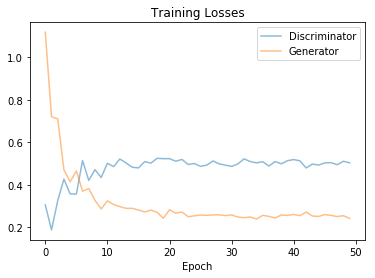

In [24]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.xlabel("Epoch")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [25]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [26]:
# Load samples from generator, taken while training
with open('train_samples_32_rmse_g.pkl', 'rb') as f:
    samples = pkl.load(f)

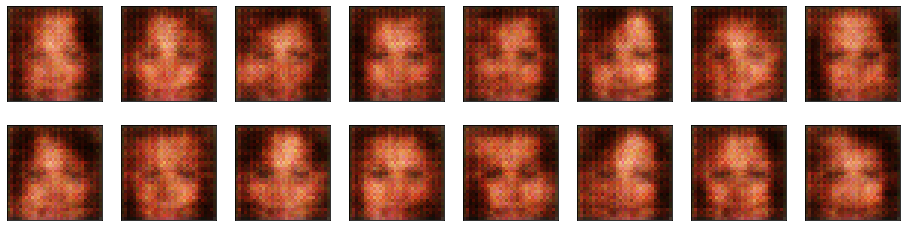

In [27]:
_ = view_samples(0, samples) # Samples at 0th iteration

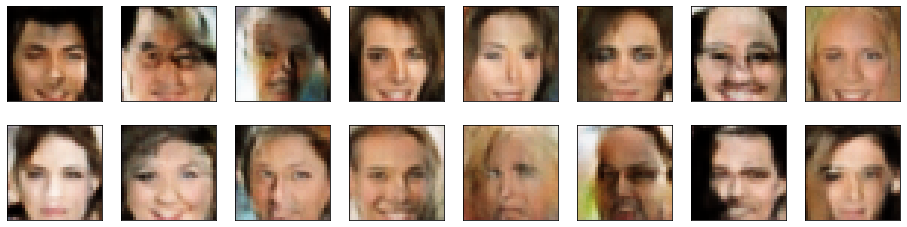

In [28]:
_ = view_samples(10, samples) # Samples at 10th iteration generated with same latent vectors

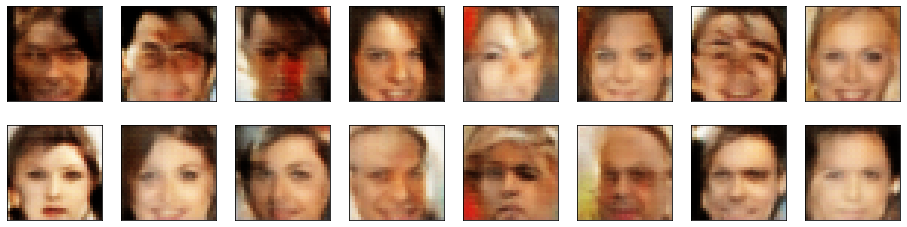

In [29]:
_ = view_samples(20, samples) # Samples at 20th iteration generated with same latent vectors

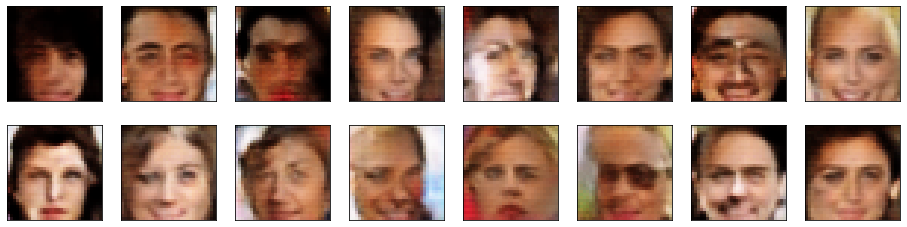

In [30]:
_ = view_samples(30, samples) # Samples at 30th iteration generated with same latent vectors

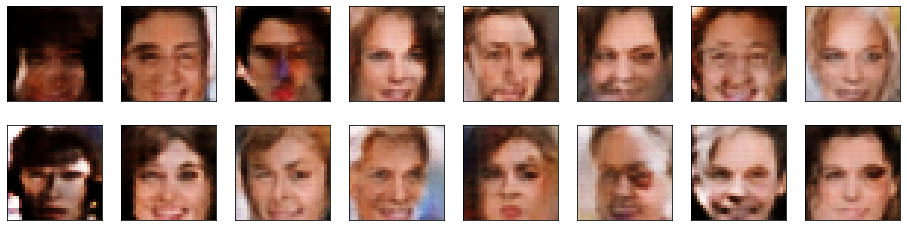

In [31]:
_ = view_samples(-1, samples) # Samples at last iteration generated with same latent vectors

## Observations

* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result
* The generated samples tend to become more and more realistic as the number of epochs increase. One can see that features such as eyes that are like dark spots initially tend to get closer to human like as the training progresses.For some faces even specific gender gets consolidated over time. For example, some faces might be half male and half female in between the tranining, and take on a specific gender as the training progresses.

* With more training with larger number of epochs, the quality of generated images will get better.

* Unlike other methods, the error graph is not interpretable with GANs.